<!-- !pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html -->

<!-- !pip install transformers -->

# Import libraries

In [1]:
# to handle data
import numpy as np
import pandas as pd

# to get sentiment from tweets
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from textblob import TextBlob
import torch

# to preprocess the text
import re

# to plot cloud of words
from wordcloud import WordCloud
import matplotlib.pyplot as plt; plt.rcParams['figure.facecolor'] = 'white' # set figure background color to white 

# Instantiate Model

In [2]:
# from https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

# Load data

In [3]:
df = pd.read_csv('gw2_newRelease.csv')

In [4]:
df.head(10)

,text
0,RT @CrucialMemory: Want to score a new SSD and...
1,Doing some #GW2EOD Meta Events before some Str...
2,That's the thing with the Claw fight. You aren...
3,RT @KoboldArt: Nothing but fishing! 🐟🎣\n#GW2EO...
4,Here's one of Jormag's kids. They're so scared...
5,Beloved Commander #GW2EOD #gw2 #GuildWars2 htt...
6,What kind of psychopath do you have to be to w...
7,That's why the story of #GW2/#GW2EOD hurt me s...
8,"This is why I don't like aphantasia, because i..."
9,So the question becomes: Why do you want to wa...


In [5]:
# Function that removes self references that do not provide information
def remove_game_name(text):
    text = re.sub(r'gw2eod', '', text) 
    text = re.sub(r'eod', '', text) 
    text = re.sub(r'guildwars2', '', text) 
    text = re.sub(r'guild', '', text) 
    text = re.sub(r'wars', '', text) 
    text = re.sub(r'gw2', '', text) 
    text = re.sub(r"dragon'?s?", '', text) 
    text = re.sub(r'end', '', text) 
    text = re.sub(r'cantha', '', text) 
    text = re.sub(r'story', '', text) 
        
    return text

In [6]:
# Create a function to clean the tweets
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #Removes @mentions
    text = re.sub(r'#', '', text) #Removes the '#' symbol
    text = re.sub(r'rt[\s]+[^a-z]', ' ', text) #Removes "RT" but no words like "art"
    text = re.sub(r'https?:\/\/\S+', '', text) #Removes hyperlinks
    text = re.sub(r'(\n)+', ' ', text) #Removes "\n"
    text = re.sub(r'@|:|_', ' ', text) #Removes remaining characters
    text = re.sub(r"'s", '', text) #Removes 's
    
    return text

In [7]:
df.text = df.text.str.lower().apply(remove_game_name)
df.text = df.text.str.lower().apply(clean_text)

#show clean text
df.text.head()

0      want to score a new ssd and a copy of     of...
1    doing some  meta events before some strikes an...
2    that the thing with the claw fight. you aren't...
3         nothing but fishing! 🐟🎣   art sponsored by  
4    here one of jormag kids. they're so scared. hi...
Name: text, dtype: object

# Score tweets

In [8]:
def sentiment_score(tweet):
    tokens = tokenizer.encode(tweet, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [9]:
%%time
df['sentiment'] = df['text'].apply(sentiment_score)

Wall time: 2min 13s


In [10]:
df.head()

,text,sentiment
0,want to score a new ssd and a copy of of...,1
1,doing some meta events before some strikes an...,4
2,that the thing with the claw fight. you aren't...,5
3,nothing but fishing! 🐟🎣 art sponsored by,5
4,here one of jormag kids. they're so scared. hi...,1


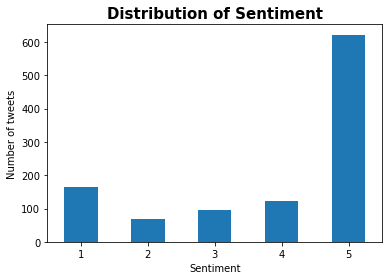

In [11]:
df.sentiment.value_counts().sort_index().plot.bar()
plt.title('Distribution of Sentiment', weight = 'bold', size = 15)
plt.ylabel('Number of tweets')
plt.xlabel('Sentiment')
plt.xticks(rotation = 0)
plt.show()

## Plot Cloud of Words

In [12]:
# ad-hoc removing of words/letters otherwise appearing in cloud though not providing real meaning
def remove_words(text):
    text = re.sub(r'let', '', text)
    text = re.sub(r'[^a-z]+s[^a-z]+', '', text)
    text = re.sub(r'stream', '', text)
    text = re.sub(r'[^a-z]+u[^a-z]+', '', text)
    text = re.sub(r'[^a-z]+3[^a-z]+', '', text)
    
    return text

In [13]:
df.text = df.text.apply(remove_words)

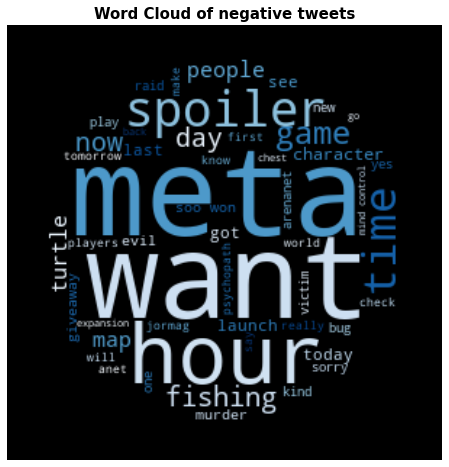

In [14]:
sent_1 = df[df.sentiment == 1]

# Create mask (=shape of word cloud)
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

# Plot Word Cloud
allWords = ' '.join( [tweets for tweets in sent_1.text] )
wordCloud = WordCloud(width = 500, height = 300, random_state = 42, max_words=50, mask=mask,
                     colormap = 'Blues').generate(allWords)

plt.figure(figsize = (17,8))
plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Word Cloud of negative tweets',  weight = 'bold', size = 15)
plt.show()

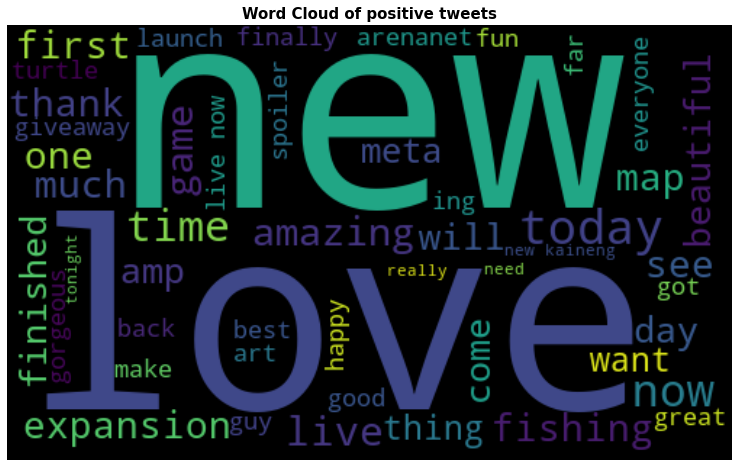

In [15]:
sent_5 = df[df.sentiment == 5]

# Plot Word Cloud
allWords = ' '.join( [tweets for tweets in sent_5.text] )
wordCloud = WordCloud(width = 500, height = 300, random_state = 42, max_words=50, #mask=mask,
                     colormap = 'viridis').generate(allWords)

plt.figure(figsize = (17,8))
plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Word Cloud of positive tweets',  weight = 'bold', size = 15)
plt.show()

## Subjectivity & Polarity

In [16]:
# Create a function to get the subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

# Create two new columns
df['subjectivity'] = df.text.apply(getSubjectivity)
df['polarity'] = df.text.apply(getPolarity)

In [17]:
df.groupby('sentiment').mean()

,subjectivity,polarity
sentiment,,
1,0.356442,0.014929
2,0.455103,0.043265
3,0.389236,0.138986
4,0.432908,0.153972
5,0.470068,0.261246


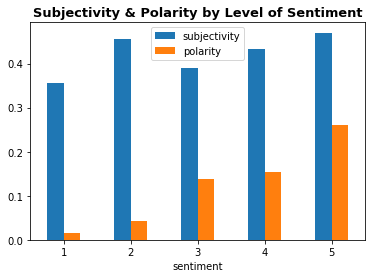

In [18]:
df.groupby('sentiment').mean().plot.bar()
plt.title('Subjectivity & Polarity by Level of Sentiment', weight = 'bold', size = 13)
plt.xticks(rotation = 0)
plt.show()